# Fine-tune Network on Danish Fungi 2020 Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from src.core import models, metrics, training, data, loss_functions
from src.utils import nb_setup
from src.dev import experiments as exp

DATA_DIR = 'data/danish_fungi_dataset/'
TRAIN_SET_DIR = 'train_resized'

SEED = 42

nb_setup.init()
nb_setup.set_random_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [2]:
# create training 
config = exp.create_config(
    data='df2020',
    model='efficientnet_b0',
    loss='ce',
    opt='sgd',
    no_epochs=30,
    batch_size=64,
    total_batch_size=64,
    learning_rate=0.01,
    weight='none',
    dataset='mini',
    scheduler='reduce_lr_on_plateau',
    # note=''
)

# include configuration from model
_model_config = models.get_model(config.model, pretrained=False).pretrained_config
config.update(_model_config)

# save config file
config.save(DATA_DIR + config.specs_name)

# create loss, optimizer and scheduler functions
loss_fn = loss_functions.LOSSES[config.loss]
weight_fn = loss_functions.WEIGHTING[config.weight]
opt_fn = training.OPTIMIZERS[config.opt]
sched_fn = training.SCHEDULERS[config.scheduler]

DATASETS = {
    'full': ('DF20-train_metadata_PROD.csv', 'DF20-public_test_metadata_PROD.csv'),
    'mini': ('DF20M-train_metadata_PROD.csv', 'DF20M-public_test_metadata_PROD.csv')
}

print(config)

Config(
* model_name: df2020_efficientnet_b0_ce_11-04-2021_19-52-55
* history_file: df2020_efficientnet_b0_ce_11-04-2021_19-52-55.csv
* specs_name: df2020_efficientnet_b0_ce_11-04-2021_19-52-55.json
* model: efficientnet_b0
* loss: ce
* opt: sgd
* no_epochs: 30
* batch_size: 64
* total_batch_size: 64
* learning_rate: 0.01
* weight: none
* dataset: mini
* scheduler: reduce_lr_on_plateau
* pretrained_checkpoint: tf_efficientnet_b0
* input_size: 224
* image_mean: (0.485, 0.456, 0.406)
* image_std: (0.229, 0.224, 0.225))


## Load the Data

In [3]:
# load metadata
train_df = pd.read_csv(DATA_DIR + DATASETS[config.dataset][0])
valid_df = pd.read_csv(DATA_DIR + DATASETS[config.dataset][1])

classes = np.unique(train_df['scientificName'])
no_classes = len(classes)
assert no_classes == len(np.unique(valid_df['scientificName']))
print(f'No classes: {no_classes}')
print(f'Train set length: {len(train_df):,d}')
print(f'Validation set length: {len(valid_df):,d}')

No classes: 182
Train set length: 32,753
Validation set length: 3,640


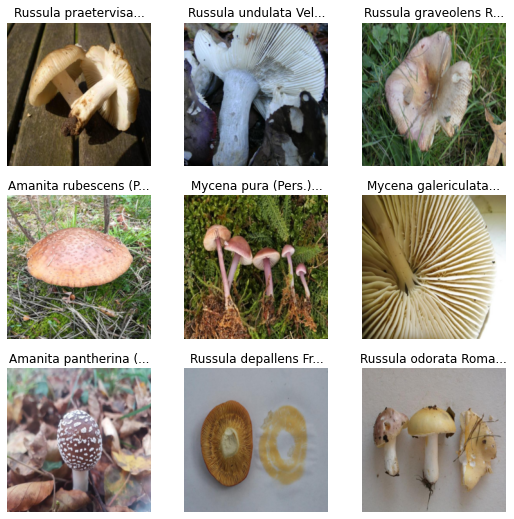

In [4]:
# create transforms
train_tfms, valid_tfms = data.get_transforms(
    size=config.input_size, mean=config.image_mean,
    std=config.image_std)

# create data loaders
trainloader = data.get_dataloader(
    train_df, img_path_col='image_path', label_col='scientificName',
    path=DATA_DIR + TRAIN_SET_DIR, transforms=train_tfms, labels=classes,
    batch_size=config.batch_size, shuffle=True, num_workers=4)
validloader = data.get_dataloader(
    valid_df, img_path_col='image_path', label_col='scientificName',
    path=DATA_DIR + TRAIN_SET_DIR, transforms=valid_tfms, labels=classes,
    batch_size=config.batch_size, shuffle=False, num_workers=4)

trainloader.dataset.show_items()

## Train the Model

In [5]:
# create model
model = models.get_model(config.model, no_classes, pretrained=True)
assert np.all([param.requires_grad for param in model.parameters()])

# create loss
freq = train_df['scientificName'].value_counts()[trainloader.dataset.labels].values
weights = weight_fn(freq)
criterion = loss_fn(weight=torch.Tensor(weights).to(device) if weights is not None else None)

# create trainer
trainer = training.Trainer(
    model,
    trainloader,
    criterion,
    opt_fn,
    sched_fn,
    validloader=validloader,
    accumulation_steps=config.total_batch_size // config.batch_size,
    path=DATA_DIR,
    model_filename=config.model_name,
    history_filename=config.history_file,
    device=device)

In [6]:
# train model
trainer.train(no_epochs=config.no_epochs, lr=config.learning_rate)

epoch,train_loss,valid_loss,accuracy,top_3,f1_score,time
0,3.377050,2.271348,0.434066,0.642582,0.205164,02:11
1,1.942178,1.797944,0.521703,0.730495,0.325825,02:07
2,1.503867,1.647204,0.543132,0.765659,0.378596,02:08
3,1.244821,1.558725,0.575824,0.774725,0.421947,02:10
4,1.038391,1.504184,0.595330,0.796154,0.455195,02:11
5,0.871426,1.523283,0.596703,0.788187,0.464823,02:10
6,0.728025,1.543315,0.596154,0.793132,0.457192,02:10
7,0.578823,1.582452,0.596978,0.791484,0.464883,02:09
8,0.471969,1.630011,0.601648,0.797802,0.471069,02:10
9,0.366547,1.627152,0.600824,0.801648,0.467032,02:11


Epoch 1 - Save Checkpoint with Best F1 Score: 0.205164
Epoch 2 - Save Checkpoint with Best F1 Score: 0.325825
Epoch 3 - Save Checkpoint with Best F1 Score: 0.378596
Epoch 4 - Save Checkpoint with Best F1 Score: 0.421947
Epoch 5 - Save Checkpoint with Best F1 Score: 0.455195
Epoch 6 - Save Checkpoint with Best F1 Score: 0.464823
Epoch     7: reducing learning rate of group 0 to 9.0000e-03.
Epoch 8 - Save Checkpoint with Best F1 Score: 0.464883
Epoch     9: reducing learning rate of group 0 to 8.1000e-03.
Epoch 9 - Save Checkpoint with Best F1 Score: 0.471069
Epoch    11: reducing learning rate of group 0 to 7.2900e-03.
Epoch 11 - Save Checkpoint with Best F1 Score: 0.491450
Epoch    13: reducing learning rate of group 0 to 6.5610e-03.
Epoch 13 - Save Checkpoint with Best F1 Score: 0.493733
Epoch    15: reducing learning rate of group 0 to 5.9049e-03.
Epoch    17: reducing learning rate of group 0 to 5.3144e-03.
Epoch 17 - Save Checkpoint with Best F1 Score: 0.502260
Epoch    19: reducin

In [7]:
# find learning rate
# lr_finder = trainer.lr_find()